In [32]:
import joblib
import pandas as pd
import numpy as np
from scipy import ndimage
import os
from matplotlib import pyplot as plt
from itertools import product
import tqdm

In [2]:
model = joblib.load('ada_class_fs.joblib')

In [137]:
images_path = '/mnt/c/Users/dandres/Documents/Class_projects/Canopy cover/20210710/Multispectral/Raw'

In [138]:
files = os.listdir(images_path)
calibration_im, files = files[0], files[1:]

In [139]:
cpf_matrix = [
    ['R', -.87, -.87, 2.74, .94],
    ['G', 3.74, -1.37, -1.37, .85],
    ['B', -1.31, 3.62, -1.31, 1.]
]
def create_image(image_path, cpf_matrix):
    with open(image_path, 'r') as infile: 
        data = np.fromfile(infile, dtype=np.uint8, count=-1)
        
    nrows = int(''.join(map(lambda x: np.binary_repr(x, 8), data[8:9+1][::-1])), 2)
    ncols = int(''.join(map(lambda x: np.binary_repr(x, 8), data[6:7+1][::-1])), 2)
    image_size = nrows * ncols
    image = data[10:image_size+10].reshape((nrows, ncols))
    B = {}
    for i, j in product((0, 1), (0, 1)): B[f'{i}{j}'] = image[i::2,j::2] #GRBG
    RGBBands = {}
    for band, Rf, Gf, Bf, Scale in cpf_matrix:
        RGBBands[band] = (Rf*B['01'] + Gf*np.mean([B['11'], B['00']], axis=0) + Bf*B['10'])*Scale
        RGBBands[band] = np.where(RGBBands[band] > 255, 255, np.where(RGBBands[band]<0, 0, RGBBands[band]))
    Image_array = (np.dstack((RGBBands['R'],RGBBands['G'],RGBBands['B']))).astype(np.uint8)
    return Image_array

In [140]:
images = {
    filename.split('.')[0]: create_image(os.path.join(images_path, filename), cpf_matrix)
    for filename in files
}

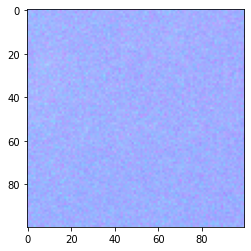

In [141]:
calibration_image = create_image(os.path.join(images_path, calibration_im), cpf_matrix)
refNIR, refR, refG =[np.median(calibration_image[400:500, 400:500, :][i]) for i in range(3)]
plt.imshow(calibration_image[400:500, 400:500, :])

In [142]:
for key in images.keys(): images[key] = images[key]/[refNIR, refR, refG]
for key in images.keys(): images[key] = np.where(images[key] > 1, 1, images[key])

In [143]:
functions = {
    'NIR': lambda x: x[:, :, 0],
    'MeanRed_ws20': lambda x: ndimage.uniform_filter(x[:, :, 1], 20),
    'P10Green_ws20': lambda x: ndimage.percentile_filter(x[:, :, 2], size=20, percentile=10),
    'Red': lambda x: x[:, :, 1],
    'MeanNIR_ws20': lambda x: ndimage.uniform_filter(x[:, :, 0], 20),
    'P10NIR_ws20': lambda x: ndimage.percentile_filter(x[:, :, 0], size=20, percentile=10),
    'GradNIR_ws20': lambda x: ndimage.uniform_filter(abs(ndimage.prewitt(x[:, :, 0], axis=0)*ndimage.prewitt(x[:, :, 0], axis=1)), 20),
}
prediction = {}
for key, image in tqdm.tqdm(images.items()):
    features = np.array([
        f(image).flatten() for f in functions.values()
    ])
    prediction[key] = model.predict(features.T).reshape(768, 1024)

100%|██████████| 54/54 [07:42<00:00,  8.56s/it]


In [145]:
images_bk = np.copy(images)
CC = pd.DataFrame([(key, value.mean()) for key, value in prediction.items()])
CC.columns = ['image', 'CC']
CC

image        CC
0   TTC02543  0.598118
1   TTC02544  0.611800
2   TTC02545  0.617283
3   TTC02546  0.702908
4   TTC02547  0.637658
5   TTC02548  0.658984
6   TTC02549  0.808726
7   TTC02550  0.765371
8   TTC02551  0.799184
9   TTC02552  0.822241
10  TTC02553  0.785058
11  TTC02554  0.797882
12  TTC02555  0.741350
13  TTC02556  0.702911
14  TTC02557  0.709897
15  TTC02558  0.779775
16  TTC02559  0.707626
17  TTC02560  0.750053
18  TTC02561  0.862045
19  TTC02562  0.891771
20  TTC02563  0.833683
21  TTC02564  0.887026
22  TTC02565  0.904538
23  TTC02566  0.869661
24  TTC02567  0.824496
25  TTC02568  0.849594
26  TTC02569  0.873264
27  TTC02570  0.849439
28  TTC02571  0.881498
29  TTC02572  0.855412
30  TTC02573  0.510939
31  TTC02574  0.521093
32  TTC02575  0.545394
33  TTC02576  0.477759
34  TTC02577  0.478030
35  TTC02578  0.470154
36  TTC02579  0.703854
37  TTC02580  0.744010
38  TTC02581  0.800439
39  TTC02582  0.797296
40  TTC02583  0.764211
41  TTC02584  0.809636
42  TTC02585  0.610442
43  TTC02586  0.562246
44  TTC02587  0.490320
45  TTC02588  0.576864
46  TTC02589  0.538834
47  TTC02590  0.546510
48  TTC02591  0.755291
49  TTC02592  0.816100
50  TTC02593  0.821449
51  TTC02594  0.828213
52  TTC02595  0.804016
53  TTC02596  0.849403

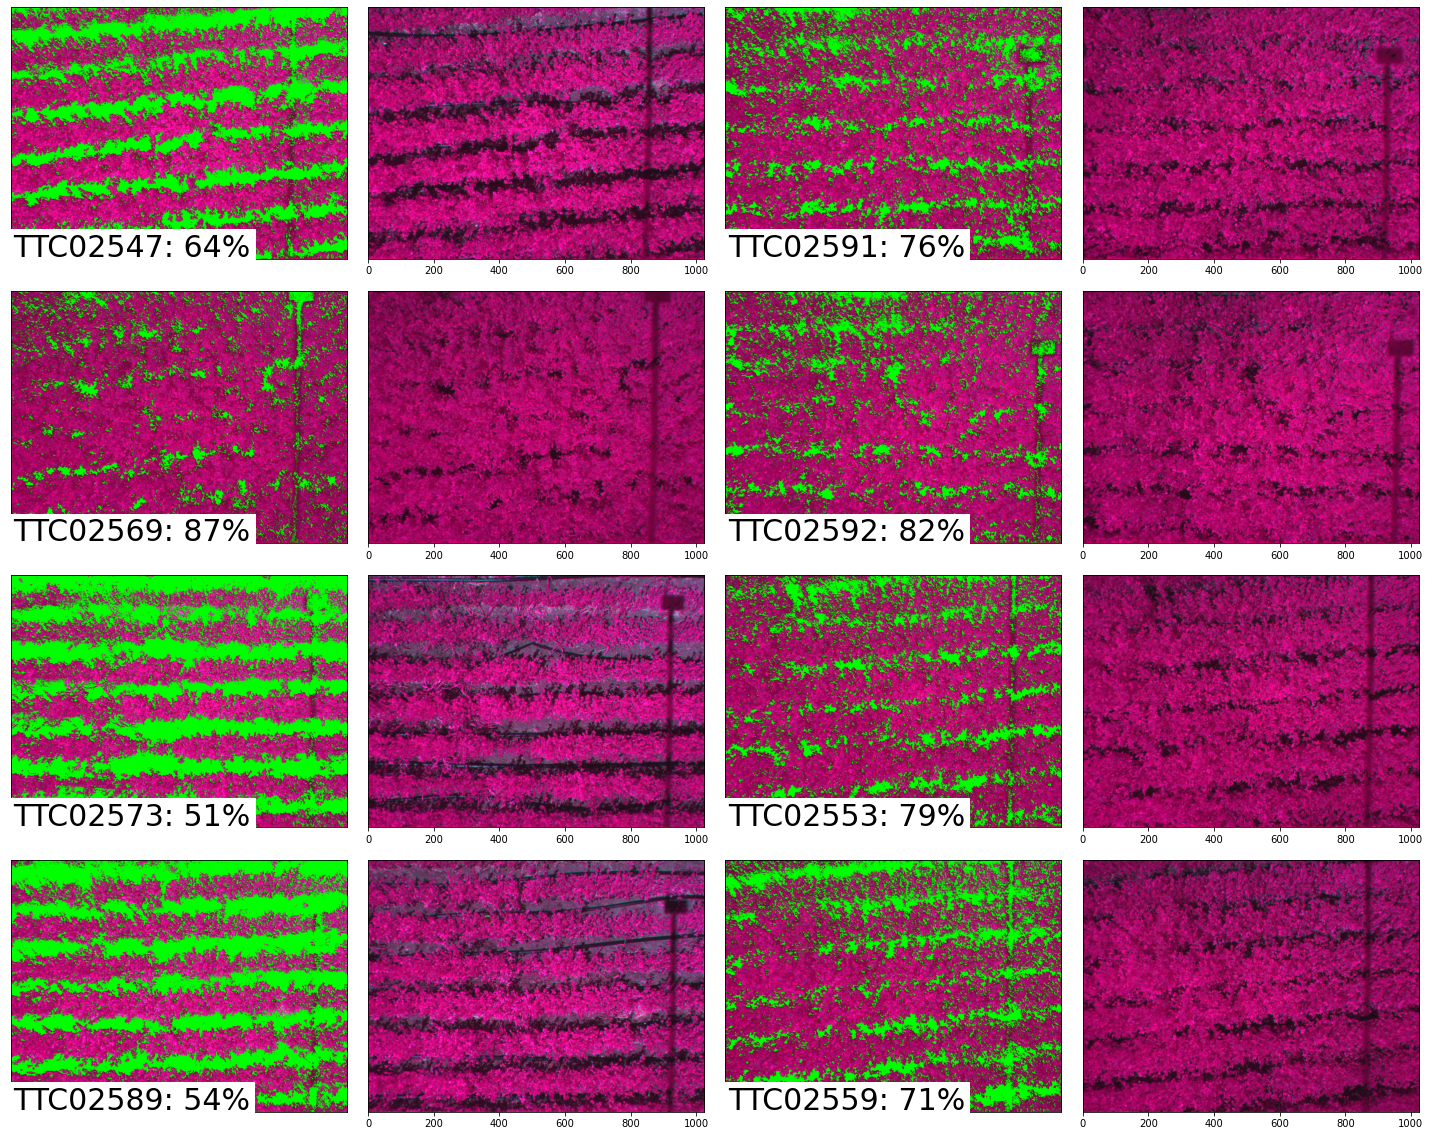

In [161]:
fig, ax = plt.subplots(4, 4, figsize=(20, 16))
ax = ax.flatten()

for n, key in enumerate(CC.image.sample(16)):
    if (n+1) % 2 == 0:
        continue
    matrix = np.copy(images[key])
    matrix[:, :, 0] = np.where(prediction[key] < 1, 0,  matrix[:, :, 0])
    matrix[:, :, 1] = np.where(prediction[key] < 1, 1,  matrix[:, :, 1])
    matrix[:, :, 2] = np.where(prediction[key] < 1, 0,  matrix[:, :, 2])
    ax[n].imshow(matrix)
    ax[n].set_yticks([]); ax[n].set_xticks([])
    ax[n+1].imshow(images[key])
    ax[n+1].set_yticks([]); ax[n].set_xticks([])
    ax[n].text(8, 760, f'{key}: {CC.loc[CC.image == key, "CC"].values[0]:.0%}', fontsize=30, backgroundcolor='white')
plt.tight_layout() 